# Pinksy-Rinzel One Parameter of Freedom #

    of finite elements specified in apply. The larger number of finite
    elements will be used.
Ipopt 3.12.12: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.12, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    40000
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    10001

Total number of variables............................:    12004
                     variables with only lower bounds:        0
                variables with lo

<IPython.core.display.Javascript object>


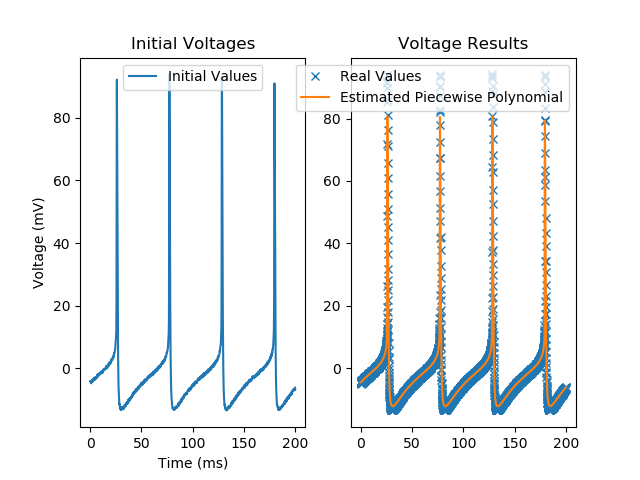

"\n#display parameter values\nprint('gL:')\nprint(value(model.gL))\nprint('gNa:')\nprint(value(model.gNa))    \nprint('gKDR:')\nprint(value(model.gKDR))\n\n#display times and values at peaks comapred to real values\ntpks = []\nvpks = []\ntlen = len(tf)\nfor ti in range(tlen):\n    if ti!=0 and ti!=(tlen-1):\n        if vf[ti] > vf[ti-1] and vf[ti] > vf[ti+1]:\n            tpks.append(tf[ti])\n            vpks.append(vf[ti])          \n           \n\n        \n#Results\nprint('Peak Times, Real Peak Times')\nprint (tpks, tpeaks)\nprint('Peak Values Estimated, Real Peak Values')\nprint (vpks, vpeaks)\nprint (vf[0])\n\n\n#fe = model.t.get_finite_elements()\n#felen = len(fe)\n#display finite elements\n#print('Finite Elements Boundaries')\n#print (fe)\n#print('Initialized Finite Elements')\n#print (fecut)\n\n#dinfo = model.t.get_discretization_info()\n#print (dinfo)\n"

In [2]:
from pyomo.environ import *
from pyomo.dae import *
import numpy as np
import scipy.io as spio
%matplotlib notebook
import matplotlib.pyplot as plt
import random
#infinity = float('inf')

#runtime of code
import timeit
start = timeit.default_timer()

#Initializing data that we will model
#Model created using time step of 0.05 and runge-kutta 4th order method for approximating steps
treal = spio.loadmat('Data/t_real.mat')
treal = [float(x) for x in treal['treal']]
trlen = len(treal)

#larger tstep prevents memory error
tstep = 2 #which times to use as finite elements boundaries, use every nth wehre (n = tstep)
trealcut = [treal[i] for i in range(0, trlen, tstep)]
tpeaks = [float(treal[519]), treal[1544], treal[2569], treal[3594]]
#tpeaks = [25.95, 77.2, 128.45, 179.7]
#Enforce Peaks
#trealcut.extend(tpeaks)
trclen = len(trealcut)
vreal = spio.loadmat('Data/v_real.mat')
vreal = [float(x) for x in vreal['vreal']]

#adding noise to data
vreal = [v + (0.5-(random.random()*1.0)) for v in vreal]
#vrealcut = [vreal[i] for i in range(0, len(vreal), 20)]
vpeaks = [vreal[i] for i in [519,1544,2569,3594]]

#hreal and nreal for help in computation
hreal = spio.loadmat('Data/hreal.mat')
hreal = [float(x) for x in hreal['hreal']]
nreal = spio.loadmat('Data/nreal.mat')
nreal = [float(x) for x in nreal['nreal']]

#Simpler Model using Is=-0.5 to test if code works (works pretty well (works better w/ collocation))
#treals = spio.loadmat('treal_Is_0.5.mat')
#treals = [float(x) for x in treals.values()[0]]
#vreals = spio.loadmat('vreal_Is_0.5.mat')
#vreals = [float(x) for x in vreals.values()[0]]

#Model created using ode23 to determine times and estimate vs (as compared to runge-kutta w/ 0.05 time step)
#treal23 = spio.loadmat('t23.mat')
#treal23 = [float(x) for x in treal23.values()[0]]
#vreal23 = spio.loadmat('v23.mat')
#vreal23 = [float(x) for x in vreal23.values()[0]]
#tpeaks23 = [float(treal23[45]), float(treal23[136]), float(treal23[227]), float(treal23[320])]
#trealcut23 = [treal[i] for i in range(0, len(treal), 50)]

#breakpoints found using ppfit to fit piecewise polynomial to data w/o ODEs
#breaks_# uses # linear (1st order) polynomials to estimate data w/o ODE, breaks is the breakpoints used
#in this estimation
breaks = spio.loadmat('Data/breaks800.mat')
breaks = [round(2*x,1) / 2 for x in breaks['breaks'][0]]
#rounding 2*x then dividing by 2 vs just rounding x in order to capture .05 second steps vs 0.1 second steps


# **Creating Model**
model = ConcreteModel()

#time (tt is total time)
model.t = ContinuousSet(bounds=(0,200), initialize=trealcut) #200 ms time and breaks as finite element boundaries
#model.tt = Var(within=PositiveReals)

#constants
Cm=3 # Membrane Capcitance uF/cm^2
dt=0.05 # Time Step ms
p = 0.5 #Fraction of cable length assigned to soma (1-p for dendtrite)
Is=0.25 #External Current Applied #can be -0.5 for simpler model, can vary this as well and see what happens
VNa=120 # mv Na reversal potential
VK=-15 # mv K reversal potential
VL=0 # mv Leakage reversal potential

#Parameters that we are solving for
#Initializing gNa doesn't seem to matter while initializing gKDR seems to make a big difference
model.gNa = Var(bounds=(1.0,50.0))#, initialize=30.0) # mS/cm^2 Na max conductance (30 real)
#model.gNa = Param(initialize=30)
#model.gKDR = Var(bounds=(1.0,50.0), initialize=15.0) # mS/cm^2 K max conductance (15 real)
model.gKDR = Param(initialize=15.0)
#model.gL = Var(within=NonNegativeReals, bounds=(0,2))#, initialize=0.1) # mS/cm^2 Leakage max conductance (0.1 real)
model.gL = Param(initialize=0.1)

#Variables
model.Vs = Var(model.t, bounds=(-15,120), initialize=-4.6)
model.h = Var(model.t, bounds=(0,1), initialize=0.001)
model.n = Var(model.t, bounds=(0,1), initialize=0.999)

#Funcions
#forward rate constant for fast sodium
def am(v):
    return 0.32*(13.1-v)/(exp((13.1-v)/4)-1)

#backward rate constant for fast sodium
def bm(v):
    return 0.28*(v-40.1)/(exp((v-40.1)/5)-1)

#forward rate constant for DR activation
def an(v):
    return 0.016*(35.1-v)/(exp((35.1-v)/5)-1)

#backward rate constant for DR activation
def bn(v):
    return 0.25*exp(0.5-0.025*v)

#forward rate constant for sodium inactivation
def ah(v):
    return 0.128*exp((17-v)/18)

#backward rate constant for sodium inactivation
def bh(v):
    return 4/(1+exp((40-v)/5))


#somatic leak current
def Ils(t):
    return model.gL*(model.Vs[t]-VL)

#steady-state sodium activation (instantaneous)
def minf(t):
    return am(model.Vs[t])/(am(model.Vs[t])+bm(model.Vs[t]))

#sodium current (y(2) is h, inactivation of sodium current)
def INa(t):
    return model.gNa*(minf(t)**2)*model.h[t]*(model.Vs[t]-VNa)

#delayed rectifier current (y(3) is n, activation of DR)
def IKDR(t):
    return model.gKDR*model.n[t]*(model.Vs[t]-VK)

#initial values
#not using initial values greatly improves performance in terms of time and memory efficiency
#and reduces objective function by small factor
#(just using initial h and n values seems to be slightly more efficient and better than using none)
#initializing Vs values leads to memory issues and the solver failing due to memory constraints
#def condi(model):
    #yield model.Vs[0] == vreal[0] # Initial Membrane voltage
    #yield model.h[0] == hreal[0] # Initial h-value
    #yield model.n[0] == nreal[0] # Initial n-value
    #yield ConstraintList.End
#model.cond = ConstraintList(rule = condi) #try without initial conditions

#Defining derrivatives
model.dVsdt = DerivativeVar(model.Vs, wrt=model.t)
model.dhdt = DerivativeVar(model.h, wrt=model.t)
model.dndt = DerivativeVar(model.n, wrt=model.t)

#Defining system governing ODE's (the model)
#Ode 2 and 3 are identical to Hodgskin-Huxley Model, Ode 1 is very similar
def _ode1(mo, t):
    if t == 0:
        return Constraint.Skip
    return mo.dVsdt[t] == (-Ils(t) - INa(t) - IKDR(t) + Is/p)/Cm
model.ode1 = Constraint(model.t, rule=_ode1)

def _ode2(mo, t):
    if t == 0:
        return Constraint.Skip
    return mo.dhdt[t] ==  ah(mo.Vs[t])*(1-mo.h[t])-bh(mo.Vs[t])*mo.h[t]
model.ode2 = Constraint(model.t, rule=_ode2)

def _ode3(mo, t):
    if t == 0:
        return Constraint.Skip
    return mo.dndt[t] == an(mo.Vs[t])*(1-mo.n[t])-bn(mo.Vs[t])*mo.n[t]
model.ode3 = Constraint(model.t, rule=_ode3)
                                    
    
#discretizer = TransformationFactory('dae.collocation')
#discretizer.apply_to(model,nfe=5,ncp=3,scheme='LAGRANGE-RADAU')
discretizer = TransformationFactory('dae.finite_difference')
discretizer.apply_to(model,nfe=1, scheme='BACKWARD') 
#nfe value will be overridden if vector passed to be initialized in continuous set (model.t), is longer than value
#assigned to nfe (solver will tell you if this occurs)

#Array of finite elements
fe = model.t.get_finite_elements()
felen = len(fe)
#Deciding which finite elements to test as
feteststep = 1
fetest = [fe[i] for i in range(0, len(fe), feteststep)]

def objfun(mo):
    myobj = 0
    for fi in fetest:
        #if ti in treal:
        #for tn in treal:
         #   if abs(ti-tn) < 0.001: #accounting for rounding error
                idx = treal.index(fi)
                #sum of error squared at each test point
                myobj += ((model.Vs[fi] - vreal[idx])**2) #maybe use absolute value here too
    return myobj
model.obj = Objective(rule = objfun)

#Using ipopt to solve this model
solver = SolverFactory('ipopt')
for ijk in range(1):
    #how many fe's to directly intialize from the real Vs value, 1 in every festep
    festep = 2
    #datafrac = 4
    #trclenp = trclen // datafrac #for only intializing say 1/4 of values
    trcrem = (trclen - 1) % festep
    trclenc = trclen - trcrem #cut off extra fes that I won't be able to estimate using basic der
                                                 #subtract 1 bc we initialize Vs[0]
    for tni in range(trclenc):
        tn = trealcut[tni]
        #tn1 = trealcut[tni+trclenp]
        #tn2 = trealcut[tni+trclenp*2]
        #tn3 = trealcut[tni+trclenp*3]
        reme = int(tni % festep)
        if reme == 0:
        #for tn in treal:
          #  if abs(ti-tn) < 0.0001: #accounting for rounding error
                #model.Vs[tn].value = vreal[tni]
                model.Vs[tn].value = vreal[tni*tstep]
                #model.Vs[tn1].value = model.Vs[tn].value
                #model.Vs[tn2].value = model.Vs[tn].value
                #model.Vs[tn3].value = model.Vs[tn].value
                
                #model.Vs[ti].value = vreal[treal.index(ti)]
                #model.h[ti].value = hreal[treal.index(tn)]
                #model.n[ti].value = nreal[treal.index(tn)]
        else:
            #model.Vs[tn].value = vreal[tni-reme] + (reme*((vreal[tni+festep-reme] - vreal[tni-reme]) / festep))
            model.Vs[tn].value = vreal[(tni-reme)*tstep] + (reme*((vreal[(tni+festep-reme)*tstep] - vreal[(tni-reme)*tstep]) / festep))
            #model.Vs[tn1].value = model.Vs[tn].value
            #model.Vs[tn2].value = model.Vs[tn].value
            #model.Vs[tn3].value = model.Vs[tn].value
            
            #model.Vs[tn].value = vreal[(tni-reme)*tstep]
    #initializing end of data that was missed b/c (trclen-1) % festep was not 0
    for tni in [trc + trclenc for trc in range(trcrem)]:
        tn = trealcut[tni]
        model.Vs[tn].value = vreal[tni*tstep]

#for plotting initailized Vs
    vi = []
    tf = []
    for ti in fe:
        vi.append(value(model.Vs[ti]))
        tf.append(ti)
        
    results = solver.solve(model, tee=True)
    #print(value(model.gNa))
    
    vf = []

    for ti in fe:
        vf.append(value(model.Vs[ti]))

    #plotting
    fig1 = plt.figure()
    plt.subplot(1,2,1)
    plt.plot(tf,vi,'-')
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage (mV)')
    plt.title('Initial Voltages')
    plt.legend(['Initial Values'])
    
    plt.subplot(1,2,2)
    plt.plot(treal,vreal,'x',tf,vf,'-')


    #runtime of code
    stop = timeit.default_timer()
    runtime = stop - start
    
    pltitgna  = 'gNa = ' + str(value(model.gNa))
    pltitgkdr = ', gKDR = ' + str(value(model.gKDR))
    pltitgl   = ', gL = ' + str(value(model.gL))
    pltite    = 'Error = ' + str(value(model.obj))
    pltittime = ', Runtime = ' + str(runtime) + ' s'
    ftextres  = 'Results: ' + pltitgna + pltitgkdr + pltitgl + '\n' + pltite + pltittime
    
    pltitfe = 'Finite Elements = ' + str(felen)
    pltitfei = ', Initialized Finite Elements = ' + str(felen // festep)
    pltitfet = ', Tested Finite Elements = ' + str(felen // feteststep)
    ftextinfo = 'Info: ' + pltitfe + pltitfei + pltitfet

    plt.figtext(0.5, -0.14, ftextres, ha="center", fontsize=12)
    plt.figtext(0.5, -0.04, ftextinfo, ha="center", fontsize=12)

    plt.title('Voltage Results')
    plt.legend(['Real Values','Estimated Piecewise Polynomial'])
    plt.show()
    fig1.savefig("fig1.pdf", bbox_inches='tight')

#Enforce Peaks = [float(treal[519]), treal[1544], treal[2569], treal[3594]]
#model.Vs[treal[519]].value = vreal[519]
#model.Vs[treal[1544]].value = vreal[1544]
#model.Vs[treal[2569]].value = vreal[2569]
#model.Vs[treal[3594]].value = vreal[3594]

'''
#display parameter values
print('gL:')
print(value(model.gL))
print('gNa:')
print(value(model.gNa))    
print('gKDR:')
print(value(model.gKDR))

#display times and values at peaks comapred to real values
tpks = []
vpks = []
tlen = len(tf)
for ti in range(tlen):
    if ti!=0 and ti!=(tlen-1):
        if vf[ti] > vf[ti-1] and vf[ti] > vf[ti+1]:
            tpks.append(tf[ti])
            vpks.append(vf[ti])          
           

        
#Results
print('Peak Times, Real Peak Times')
print (tpks, tpeaks)
print('Peak Values Estimated, Real Peak Values')
print (vpks, vpeaks)
print (vf[0])


#fe = model.t.get_finite_elements()
#felen = len(fe)
#display finite elements
#print('Finite Elements Boundaries')
#print (fe)
#print('Initialized Finite Elements')
#print (fecut)

#dinfo = model.t.get_discretization_info()
#print (dinfo)
'''
